# ------------------------------------- Introduction -------------------------------------

Based on the Research Paper **"Adaptive Multimodal Continuous Ant Colony Optimization"**
This project implements a *local search-based optimization algorithm* using **Ant Colony Optimization (ACO)** to solve various fitness functions.

The goal is to explore the search space and converge toward optimal or near-optimal solutions across multiple functions.

The notebook details the algorithm's implementation, key steps, and performance evaluation, with visualizations to analyze the results.

# ------------------------------------- Implementation -----------------------------------

## Libraries used:

In [2]:
import numpy as np                   # For all of the numerical operations including handling of arrays
import inspect                       # For retrieveing function signatures to see fitness function dimensionality
import pandas as pd                  # To better display output
import matplotlib.pyplot as plt      # For visualising of fitness functions and our solution wrt to it.

## Fitness Functions:
Provided in **"Benchmark Functions for CEC’2013"**

Fitness functions ranging from F1 - F10 having different input ranges and dimensionality.

In [3]:
# F1: Five-Uneven-Peak Trap

# Dimensionality can be seen as 1, as takes in 1 input parameter
# Variqble x range in F1 is 0-30 inclusive

def F1(x):
    if x < 0 or x > 30:
        return -100
    if x < 2.5:
        return 80 * (2.5 - x)
    elif x < 5.0:
        return 64 * (x - 2.5)
    elif x < 7.5:
        return 64 * (7.5 - x)
    elif x < 12.5:
        return 28 * (x - 7.5)
    elif x < 17.5:
        return 28 * (17.5 - x)
    elif x < 22.5:
        return 32 * (x - 17.5)
    elif x < 27.5:
        return 32 * (27.5 - x)
    elif x <= 30:
        return 80 * (x - 27.5)
    else:
        return -100

In [4]:
# F2: Equal Maxima

# Dimensionality is 1
# Variable x range in F2 is 0-1 inclusive

def F2(x):
    if 0 <= x <=1:
        return (np.sin(5 * np.pi * x)) ** 6
    else:
        return -0.5

In [5]:
# F3: Uneven Decreasing Maxima

# Dimensionality is 1
# Variable x range in F3 is 0-1 inclusive

def F3(x):
    if 0 <= x <=1:
        return np.exp(-2 * np.log(2) * ((x - 0.08) / 0.854) ** 2) * (np.sin(5 * np.pi * (x ** (3/4) - 0.05))) ** 6
    else:
        return -0.5

In [6]:
# F4: Himmelblau

# Dimensionality is 2
# Variable x and y range in F4 is -6 to 6 inclusive

def F4(x, y):
    if -6 <= x <= 6 and -6 <= y <= 6:
        return 200 - ((x**2 + y - 11)**2 + (x + y**2 - 7)**2)
    else:
        return -0.5

In [7]:
# F5: Six-Hump Camel Back

# Dimensionality is 2
# Variable x range in F5 is -1.9 to 1.9 inclusive
# Variable y range in F5 is -1.1 to 1.1 inclusive

def F5(x, y):
    if -1.9 <= x <= 1.9 and -1.1 <= y <= 1.1:
        return -1 * ((4 - 2.1 * x**2 + x**4 / 3) * x**2 + x * y + (4 * y**2 - 4) * y**2)
    else:
        return -0.5

In [8]:
# F6: Shubert

# Dimensionality is set as 4 and is bound to change at runtime
# Variable x range in F6 is -10 to 10 inclusive

def F6(x1, x2, x3, x4):
    # Combine all parameters into a single numpy array
    x = np.array([x1, x2, x3, x4])

    # Check the bounds (-10 to 10 for each dimension)
    if np.all((-10 <= x) & (x <= 10)):
        answer = 1.0
        D = len(x)  # Dimension is now explicitly 4
        for i in range(D):
            sum_val = 0.0
            for j in range(1, 6):
                sum_val += j * np.cos((j + 1) * x[i] + j)
            answer *= sum_val
        return -answer  # Negate the result as per the problem definition
    else:
        return -0.5

In [9]:
# F7: Vincent

# Dimensionality is set as 4 but is bound to change at runtime
# Variable x range in F7 is 0.25 to 10 inclusive

def F7(x1, x2, x3, x4):
    # Convert to numpy array using a list
    x = np.array([x1, x2, x3, x4])

    if np.all((0.25 <= x) & (x <= 10)):
        return np.mean(np.sin(10 * np.log(x)))
    else:
        return -0.5

In [43]:
# F8: Modified Rastrigin - All Global Optima

# Dimensionality is 1
# Variable x range in F7 is 0 to 1 inclusive

import numpy as np

def F8(x, k):

    if np.any(x < 0) or np.any(x > 1):
        raise ValueError("All elements of x must be within the range [0, 1].")

    term = 10 + 9 * np.cos(2 * np.pi * k * x)
    result = -np.sum(term)

    return result

In [11]:
# F9 - Composite Function 01

# Griewank's function
def griewank(x):
    sum_part = np.sum(x**2) / 4000
    prod_part = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return sum_part - prod_part + 1

def weierstrass(x, a=0.5, b=3, k_max=20):
    D = len(x)
    result = 0
    for i in range(D):
        for k in range(k_max + 1):
            result += a*k * np.cos(2 * np.pi * b*k * (x[i] + 0.5))
    constant = D * sum(a*k * np.cos(2 * np.pi * b*k * 0.5) for k in range(k_max + 1))
    return result - constant

def sphere(x):
    return np.sum(x**2)

# Composition Function 1
def F9(x1, x2, x3, x4):
    n = 6  # number of basic functions
    D = len(x)  # dimensionality
    functions = [griewank, griewank, weierstrass, weierstrass, sphere, sphere]
    lambdas = [1, 1, 8, 8, 1/5, 1/5]
    sigmas = [1] * n
    M = [np.identity(D) for _ in range(n)]  # Identity matrices Mi
    O = [np.zeros(D) for _ in range(n)]  # Shifting vectors, assumed zero unless specified

    weights = []
    function_values = []

    # Calculating the weights and function values
    for i in range(n):
        z = (x - O[i]) / lambdas[i]
        fi = functions[i](np.dot(M[i], z))
        function_values.append(fi)
        wi = np.exp(-np.sum((x - O[i])*2) / (2 * D * sigmas[i]*2))
        weights.append(wi)

    # Normalize weights
    weights = np.array(weights)
    weight_sum = np.sum(weights)
    if weight_sum == 0:
        weights = np.ones(n) / n
    else:
        weights /= weight_sum

    result = np.sum(weights * (np.array(function_values) + np.array([lambdas[i] for i in range(n)])))
    return result

In [12]:
# F10 Composite Function #02

# Rastrigin's function
def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# Weierstrass function
def weierstrass(x, a=0.5, b=3, k_max=20):
    D = len(x)
    result = 0
    for i in range(D):
        for k in range(k_max + 1):
            result += a*k * np.cos(2 * np.pi * b*k * (x[i] + 0.5))
    constant = D * sum(a*k * np.cos(2 * np.pi * b*k * 0.5) for k in range(k_max + 1))
    return result - constant

# Griewank's function
def griewank(x):
    sum_part = np.sum(x**2) / 4000
    prod_part = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return sum_part - prod_part + 1

# Sphere function
def sphere(x):
    return np.sum(x**2)

# Composition Function 2
def F10(x1, x2, x3, x4):
    n = 8  # number of basic functions
    D = len(x)  # dimensionality
    functions = [rastrigin, rastrigin, weierstrass, weierstrass, griewank, griewank, sphere, sphere]
    lambdas = [1, 1, 10, 10, 1/10, 1/10, 1/7, 1/7]
    sigmas = [1] * n
    M = [np.identity(D) for _ in range(n)]  # Identity matrices Mi
    O = [np.zeros(D) for _ in range(n)]  # Shift vectors, assumed zero unless specified

    weights = []
    function_values = []

    # Calculate weights and function values
    for i in range(n):
        z = (x - O[i]) / lambdas[i]
        fi = functions[i](np.dot(M[i], z))
        function_values.append(fi)
        wi = np.exp(-np.sum((x - O[i])*2) / (2 * D * sigmas[i]*2))
        weights.append(wi)

    # Normalize weights
    weights = np.array(weights)
    weight_sum = np.sum(weights)
    if weight_sum == 0:
        weights = np.ones(n) / n  # Equal weights if all are zero
    else:
        weights /= weight_sum

    # Compute the final composite function value
    result = np.sum(weights * (np.array(function_values) + np.array([lambdas[i] for i in range(n)])))
    return result

## Implemenation of Algorithm 1: "Clustering for Crowding"

### Overview:
This algorithm groups a population into smaller clusters based on proximity using a reference point.

It calculates distances from a random reference point to all individuals and forms clusters of the closest individuals.

This approach maintains diversity in optimization problems by grouping similar solutions together efficiently.
### Explanation in terms of Ants:
This Algorithm shows how ants cluster based on proximity. The population represents ants, and the reference point acts as a random pheromone marker.

Ants closest to this marker form a cluster (crowd), with the cluster size given as parameter in this function.

Once clustered, the selected ants are removed, and the process repeats until all ants are grouped, simulating natural crowding behavior.

In [13]:
def clustering_for_crowding(P, M):

    # P - Population
    # M - Cluster Size
    # R - Reference Point

    # Returns a list of Numpy Array having a set of Crowds (Clusters)

    # As a Reference Point is needed to be generated, the Upper and Lower Bounds of the Population Solutions must be found
    lower_bound = np.min(P, axis=0)
    upper_bound = np.max(P, axis=0)

    # Now using the bounds, a Reference Point between the bounds is randomly generated
    R = np.random.uniform(lower_bound, upper_bound)

    # Then the Euclidean distance is calculated from Reference Point to each Solution in the Population (Solution Set)
    euclidean_distances = np.linalg.norm(P - R, axis=1)

    # An empty Array of Cluster List is generated
    cluster_list = []

    # Process of Clustering done inside a Loop so no unclustered Individuals left in the Population.
    while len(P) > 0:

        # The index of the minimum value is found from the euclidean_distances array
        P_near_index = np.argmin(euclidean_distances)

        # The member who is present at that index is retreieved
        P_near = P[P_near_index]

        # Now distances are calculated from that member to all other memebers
        member_distances = np.linalg.norm(P - P_near, axis=1)

        # Then the nearest M individuals are selected (includes the indice itself too)
        nearest_indices = np.argsort(member_distances)[:M]

        # The M Individuals selected are then stored in current Cluster
        current_cluster = P[nearest_indices]

        # Now this Cluster Created is added in the Cluster List
        cluster_list.append(current_cluster)

        # Now the P and distances Arrays are updated, removing the values which are already used now to form clusters
        P = np.delete(P, nearest_indices, axis=0)
        euclidean_distances = np.delete(euclidean_distances, nearest_indices)

    return cluster_list

## Implemenation of Algorithm 2: "Clustering for Speciation"

### Overview:
This algorithm groups solutions into species based on fitness. The population is sorted, and the best-performing solution is selected as a seed.

Nearby solutions are clustered into a species of fixed size, and these are removed from the population.

This process continues until all solutions are grouped, ensuring similar solutions form distinct species.

### Explanation in terms of Ants:
This algorithm demonstrates how ants form species based on fitness. The population represents ants, sorted by their strength (fitness).

The strongest ant acts as the seed and gathers nearby ants (M-1 closest in fitness) to form a species.

Once grouped, these ants are removed, and the process repeats with the next strongest ant, ensuring natural clustering based on performance.


In [14]:
def clustering_for_speciation(P, M):

    # P - Population
    # M - Cluster Size

    # Returns a list of Numpy Array having a set of Species (Clusters)

    # First, it is checked if P is a 2D array and each element in P has two sub-elements
    # This sees if each individual in the population has two features
    if P.ndim == 2 and P.shape[1] == 2:

        # *ind unpacks an individual's features for the fitness function.
        fitness = np.array([fitness_function(*point) for point in P])

    else:

        # This is used when individuals do not specifically have two features.
        fitness = np.array([fitness_function(point) for point in P])


    # Then indices of fitness are sorted in descending order.
    # np.argsort sorts in ascending order, so -ve sign added with fitness to get descending order.
    sorted_Indexes = np.argsort(-fitness)

    # Reorder P according to sorted_indices to get the sorted population by fitness.
    sorted_P = P[sorted_Indexes]

    # An empty Array of Cluster List is generated
    cluster_list = []

    # Process of Clustering done inside a Loop so no unclustered Individuals left in the Population.
    while len(sorted_P) > 0:

        # The first individual from the sorted list selected as the best individual.
        P_best = sorted_P[0]

        # Calculate the number of individuals to include in the current species.
        # Check if the remaining population is less than the desired cluster size.
        if len(sorted_P) < M:

            # If fewer individuals are left than M, take all remaining individuals.
            current_cluster = sorted_P
        else:

            # Otherwise, take the first M individuals from sorted_population.
            current_cluster = sorted_P[:M]

        # Add the current species to the species list.
        cluster_list.append(current_cluster)

        # Remove the individuals that have been grouped into the current species.
        sorted_P = sorted_P[M:]

    # Return the list of species after all individuals have been grouped.
    return cluster_list

## Implemenation of Algorithm 4: "Solution Construction For Ants"

### Overview:
This Algorithm dynamically adjusts a parameter called sigma, based on local and global fitness spreads within a population of solutions.

The algorithm calculates the local fitness range for each niche or cluster and compares it to the global fitness range across the entire population.

The sigma parameter is then adjusted using an exponential function to scale the differences, which is crucial for maintaining diversity and adaptability in evolutionary computations.

The goal is to fine-tune the search behavior of the algorithm, enhancing exploration in areas with high local variability relative to the global context.

### Explanation in terms of Ants:
This algorithm demonstrates how ants form species based on fitness. The population represents ants, sorted by their strength (fitness).

The strongest ant acts as the seed and gathers nearby ants (M-1 closest in fitness) to form a species.

Once grouped, these ants are removed, and the process repeats with the next strongest ant, ensuring natural clustering based on performance.

#### Note:
This Algorithm uses Mathematical Functions which are defined seperately below.


In [15]:
# Implementation of Algorithm 4's Helper Functions:

# Converts weights into probabilities to decide how likely each individual is to be picked
# Named as function (1) in Paper
def select_probabilities(item_weights):

    cumulative_weight = np.sum(item_weights)            # Sum up all the weights in the list
    probabilities =  item_weights / cumulative_weight   # Normalize weights to create probabilities
    return probabilities

# Assigns weights to individuals, with higher ranks getting more importance, using a formula based on Gaussian distribution
# Named as s function (2) in Paper
def compute_distribution(normalization_factor, population_size):

    distribution_weights = np.zeros(population_size)  # Initialize array to store weights for each element

    for index in range(population_size):
        position = index + 1                          # Calculate the rank for Gaussian distribution
        distribution_weights[index] = 1 / (normalization_factor * population_size * np.sqrt(2 * np.pi)) * \
                                      np.exp(-((position - 1) ** 2) / (2 * normalization_factor ** 2 * population_size ** 2))
    return distribution_weights


# Named as function (3) in Paper
# Creates new solutions by generating random values around a given mean and spread.
def gaussian_function(mu, delta):               # Inbuilt Function is present

    # mu - mean
    # delta - std. deviation

    sample = np.random.normal(mu, delta)        # Return a random sample from a Gaussian distribution with mean 'mu' and standard deviation 'delta'
    return sample


# Named as function (4) in Paper
# Measures how spread out the population is around the seed to guide sampling
def calculate_standard_deviation(xi, NS, solutions, mu):

    # xi - scaling factor
    # NS - Population
    # mu - mean

    std_deviation = xi * np.sum(np.abs(solutions - mu)) / (NS - 1)
    return std_deviation


# Named as function (5) in Paper
# Dynamically adjusts the scaling parameter (sigma) based on fitness spread locally and globally
def calculate_sigma(FSmax, FSmin, FSmax_global, FSmin_global, epsilon=0.01):

    sigma = 0.1 + 0.3 * np.exp((FSmax - FSmin) / (FSmax_global - FSmin_global + epsilon))
    return sigma


# Named as function (6) in Paper
# Adjusts an individual’s position by moving it closer to a reference point (seed) based on a scaling value
def calculate_mu(x_j, x_seed, F):
    return x_j + F * (x_seed - x_j)

In [16]:
def solution_construction_for_ants(niche_size, niche_clusters, global_max_fit, global_min_fit):

    # To store new solutions
    generated_solutions = []

    # This finds the number of parameters of the fitness function
    fitness_params_count = len(inspect.signature(fitness_function).parameters)

    # We then iterate over each cluster (niche)
    for cluster_index, cluster in enumerate(niche_clusters):

        # The size of the current niche is checked
        current_niche_size = len(cluster)

        # Fitness function applied and fitness values for all members of the niche are found
        niche_fitness_scores = [
            fitness_function(*individual) if fitness_params_count > 1 else fitness_function(individual[0])
            for individual in cluster
        ]

        # Fitness values are converted into a NumPy array for numerical operations
        niche_fitness_array = np.array(niche_fitness_scores)

        # 1. The max and min fitness is found
        niche_max_fit = np.max(niche_fitness_array)
        niche_min_fit = np.min(niche_fitness_array)

        # 2. Scaling Factor is calculated using Function-5
        # This controls how the fitness values influence solution creation within the niche
        scaling_factor = calculate_sigma(niche_max_fit, niche_min_fit, global_max_fit, global_min_fit)

        # 3. Generate weights for the niche using the scaling factor and current niche size
        # This is done using Function-2
        selection_weights = compute_distribution(scaling_factor, current_niche_size)

        # 4. Normalize the weights to produce probabilities for selecting individuals
        # This is done using Function-1
        selection_probabilities = select_probabilities(selection_weights)

        # New solutions generated for the current niche
        niche_new_solutions = []

        for ant_index in range(niche_size):

            # Step 1.4.1: Select an individual probabilistically using the computed probabilities
            chosen_index = np.random.choice(current_niche_size, p=selection_probabilities)

            selected_ant = cluster[chosen_index]

            # Determine the mean (mu) for Gaussian sampling
            # Either use the selected individual or calculate it using another individual from the niche
            if np.random.rand() <= 0.5:

                mean_value = selected_ant

            else:

                # Choose another seed randomly from the niche and compute mu
                another_seed = cluster[np.random.choice(current_niche_size)]
                scale_factor = 0.5

                # This is done using Function-6
                mean_value = calculate_mu(selected_ant, another_seed, scale_factor)

            # Use xi as a scaling factor parameter for scaling the standard deviation
            diversity_factor = 0.1

            # Thi is done using Function-4
            std_deviation = calculate_standard_deviation(diversity_factor, niche_size, cluster, mean_value)

            # Sample around the mean with the calculated standard deviation
            # This is done using Function-3
            solution = gaussian_function(mean_value, std_deviation)
            niche_new_solutions.append(solution)

        generated_solutions.extend(niche_new_solutions)

    return generated_solutions

## Implemenation of Algorithm 5: "Adaptive Local Search"

### Overview:
This algorithm refines solution performance by selectively adjusting those with promising fitness scores.

Each solution is tweaked slightly multiple times, and if a new variation proves to be more effective, it is retained.

This iterative fine-tuning process helps identify and enhance the best solutions gradually.
### Explanation in terms of Ants:
Think of this Algorithm as each ant in the colony finding a slightly different path (solution) from their current one.

If the new path proves to be better (higher fitness), the ant remembers and sticks to this improved path.

This process repeats several times for ants that initially show promising paths, helping the colony gradually find the best routes to food sources.

In [17]:
def adaptive_local_search(solutions, fitness_scores, deviation, num_iterations):

    # Check the number of Arguments
    fitness_params_count = len(inspect.signature(fitness_function).parameters)

    # Calculate the size of the solutions
    number_of_solutions = len(solutions)

    # 1. minimum and maximum fitness scores
    minimum_fitness = np.min(fitness_scores)
    maximum_fitness = np.max(fitness_scores)

    # Small positive constant to prevent division by zero in calculations
    epsilon = 0.01

    # 2. To adjust fitness scores if necessary
    fitness_adjustment = abs(minimum_fitness) + epsilon
    adjusted_maximum_fitness = maximum_fitness + fitness_adjustment

    # Flag to determine if fitness adjustment is necessary
    adjust_fitness = minimum_fitness <= 0

    # Initialize a probability array for determining whether to perform local search on each solution
    probabilities = np.zeros(number_of_solutions)

    # Compute probabilities based on adjusted fitness scores
    for i in range(number_of_solutions):

        if adjust_fitness:

            # Adjust probability calculation when the minimum fitness score is less than or equal to zero
            adjusted_fitness = fitness_scores[i] + fitness_adjustment
            probabilities[i] = adjusted_fitness / (adjusted_maximum_fitness)

        else:
            # Calculate probability directly from the fitness scores
            probabilities[i] = fitness_scores[i] / maximum_fitness

    # Iterate over each solution based on its probability to undergo local search
    for i in range(number_of_solutions):

        random_chance = np.random.rand()
        if random_chance <= probabilities[i]:

            # Perform local search on this solution 'num_iterations' times
            for j in range(num_iterations):

                # Generate a new solution around the current one using a Gaussian distribution
                local_search_solution = np.random.normal(solutions[i], deviation, solutions[i].shape)

                # Evaluate the new solution using the fitness function
                # If the function accepts multiple arguments, unpack the array into arguments
                fitness_of_local_search = (
                    fitness_function(*local_search_solution) if fitness_params_count > 1 else fitness_function(local_search_solution[0])
                )

                # If the new solution has better fitness, update the current solution and its fitness score
                if fitness_of_local_search > fitness_scores[i]:

                    solutions[i] = local_search_solution
                    fitness_scores[i] = fitness_of_local_search

    # Return the updated list of solutions and their fitness scores
    return solutions, fitness_scores

## Implemenation of Algorithm 6: "Local Search-Based AMC-ACO (LAMC-ACO)"

### Overview:
This algorithm is designed to optimize a population of solutions by iteratively updating them based on fitness evaluations.

It combines global and local search methods to explore and exploit the search space effectively.

The process involves creating an initial population, evaluating fitness, and then entering a loop that includes clustering for crowding, solution construction, updating the population with better solutions, and local search enhancements until a stopping criterion (such as maximum fitness evaluations or convergence) is met.

### Explanation in terms of Ants:
Imagine a colony of ants searching for food. Each ant represents a potential solution, with the fittest ants being those that have found the most efficient paths to food sources.

Initially, all ants explore randomly within defined boundaries. As they discover food, the paths of ants closer to better sources are adjusted slightly to explore nearby areas more thoroughly, mimicking the clustering and local search steps.

This iterative process continues, refining the paths based on continuous feedback from the environment (fitness evaluations) until the paths are optimized or no further improvements can be made.

The algorithm ensures that the colony collectively improves its foraging efficiency, adapting over time to converge on the best available food sources.

In [18]:



#def Local_Search_Based_AMC_ACO(NP, G, local_search_deviation):
    # The convergence threshold
    convergence_tolerance = 1e-6

    # The max number of iterations where convergence does not change
    max_stagnation_rounds = 20

    # Check the dimensionality
    fitness_params_count = len(inspect.signature(fitness_function).parameters)

    # Initialize a counter for the number of fitness evaluations performed
    fitness_evaluations = 0

    # Initialize an array to hold the population with dimensions (NP x fitness_params_count)
    population = np.zeros((NP, fitness_params_count))

    # Initialize an array to store the fitness of each individual
    fitness_values = np.zeros(NP)

    # Handle lower and upper bounds for each parameter
    # If single parameter, lower_bound and upper_bound are scalar values
    # If multiple parameters, they are arrays of the same length as fitness_params_count
    lower_bounds = np.array(lower_bound if isinstance(lower_bound, (list, np.ndarray)) else [lower_bound] * fitness_params_count)
    upper_bounds = np.array(upper_bound if isinstance(upper_bound, (list, np.ndarray)) else [upper_bound] * fitness_params_count)

    # Generate initial population and evaluate fitness
    for individual_index in range(NP):
        # Randomly generate initial solutions within the defined bounds
        population[individual_index] = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(fitness_params_count)
        # Evaluate the fitness of each solution
        fitness_values[individual_index] = fitness_function(*population[individual_index])
        # Increment the fitness evaluation counter
        fitness_evaluations += 1

    print('Population Generated:')
    print(population)

    print('Corresponding Fitness:')
    print(fitness_values)

    # Track the best fitness found in the initial population
    best_fitness_so_far = np.min(fitness_values)

    # Initialize a counter for the number of consecutive iterations without significant improvement
    no_improvement_count = 0

    while fitness_evaluations < Max_Fes:
        print(f"\n--- Iteration with {fitness_evaluations}/{Max_Fes} Fitness Evaluations ---")

        # Determine the current maximum and minimum fitness in the population
        current_max_fitness = np.max(fitness_values)
        current_min_fitness = np.min(fitness_values)
        print(f"FSmax: {current_max_fitness}, FSmin: {current_min_fitness}")

        # Randomly select a niching size from the provided options
        niching_size = np.random.choice(G)
        print(f"Niching Size NS: {niching_size}")

        # Cluster the population to manage crowding
        clusters = clustering_for_crowding(population, niching_size)
        print('\nUsing Algorithm 1 to create Clusters: ', clusters)

        # Generate new solutions based on the clustering
        new_solutions = solution_construction_for_ants(niching_size, clusters, current_max_fitness, current_min_fitness)
        print('Using Algorithm 4 to create new Solutions: ')
        print('New Population:', new_solutions)


        # Update population with new solutions if they are better
        for new_solution in new_solutions:
            # Calculate the distance from each new solution to all existing solutions
            distances_to_existing_solutions = np.linalg.norm(population - new_solution, axis=1)

            # Find the index of the nearest existing solution
            nearest_solution_index = np.argmin(distances_to_existing_solutions)

            # Evaluate the fitness of the new solution
            new_solution_fitness = fitness_function(*new_solution)

            # Increment the fitness evaluation counter
            fitness_evaluations += 1

            if fitness_evaluations >= Max_Fes:  # Check if maximum evaluations reached
                print(f"Reached Max_Fes: {Max_Fes}. Terminating...")
                return population, fitness_values

            # Replace the nearest solution if the new one is better
            if new_solution_fitness < fitness_values[nearest_solution_index]:
                population[nearest_solution_index] = new_solution
                fitness_values[nearest_solution_index] = new_solution_fitness

        print("Updated Population after Algorithm 4:")
        print(population)
        print("Corresponding Fitness:")
        print(fitness_values)

        # Perform local search on a subset of the population
        number_of_local_searches = max(1, int(0.1 * NP))

        print('Using Algorithm 5 for Local Search: ')
        population, fitness_values = adaptive_local_search(population, fitness_values, local_search_deviation, number_of_local_searches)


        fitness_evaluations += number_of_local_searches  # Account for the additional evaluations during local search

        if fitness_evaluations >= Max_Fes:  # Stop if max evaluations reached during local search
            print(f"Reached Max_Fes: {Max_Fes}. Terminating...")
            break

        print("Updated Population after Algorithm 5: ", population)
        print("Corresponding Fitness:", fitness_values)

        # Check for improvements in the best fitness found
        current_best_fitness = np.min(fitness_values)

        if abs(best_fitness_so_far - current_best_fitness) < convergence_tolerance:
            no_improvement_count += 1
            print(f"Convergence check: No significant improvement in best fitness for {no_improvement_count} consecutive iterations.")
        else:
            no_improvement_count = 0  # Reset if there's an improvement

        if no_improvement_count >= max_stagnation_rounds:
            print(f"Convergence detected. Terminating after {no_improvement_count} iterations with no improvement.")
            break

        best_fitness_so_far = current_best_fitness  # Update the track of the best fitness for the next iteration

    return population, fitness_values


IndentationError: unexpected indent (902215890.py, line 3)

In [19]:
def Local_Search_Based_AMC_ACO(NP, G, local_search_deviation):

    # Improve array printing
    np.set_printoptions(precision=4, suppress=True)

    # The convergence threshold
    convergence_tolerance = 1e-6

    # The max number of iterations where convergence does not change
    max_stagnation_rounds = 20

    # Check the dimensionality
    fitness_params_count = len(inspect.signature(fitness_function).parameters)

    # Initialize a counter for the number of fitness evaluations performed
    fitness_evaluations = 0

    # Initialize an array to hold the population with dimensions (NP x fitness_params_count)
    population = np.zeros((NP, fitness_params_count))

    # Initialize an array to store the fitness of each individual
    fitness_values = np.zeros(NP)

    # Handle lower and upper bounds for each parameter
    lower_bounds = np.array(lower_bound if isinstance(lower_bound, (list, np.ndarray)) else [lower_bound] * fitness_params_count)
    upper_bounds = np.array(upper_bound if isinstance(upper_bound, (list, np.ndarray)) else [upper_bound] * fitness_params_count)

    # Generate initial population and evaluate fitness
    for individual_index in range(NP):

        # Randomly generate initial solutions within the defined bounds
        population[individual_index] = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(fitness_params_count)

        # Evaluate the fitness of each solution
        fitness_values[individual_index] = fitness_function(*population[individual_index])

        # Increment the fitness evaluation counter
        fitness_evaluations += 1

    print("\n" + "="*50)
    print("Population Generated:")

    # Converting to DataFrame for better readability
    col_names = [f"x{i+1}" for i in range(fitness_params_count)]
    df_population = pd.DataFrame(population, columns=col_names)
    print(df_population)

    print("\nCorresponding Fitness:")
    df_fitness = pd.DataFrame(fitness_values, columns=["Fitness"])
    print(df_fitness)

    # Track the best fitness found in the initial population
    best_fitness_so_far = np.min(fitness_values)

    # Initialize a counter for the number of consecutive iterations without significant improvement
    no_improvement_count = 0

    while fitness_evaluations < Max_Fes:
        print("\n" + "-"*50)
        print(f"Iteration: {fitness_evaluations}/{Max_Fes} Fitness Evaluations")

        # Determine the current maximum and minimum fitness in the population
        current_max_fitness = np.max(fitness_values)
        current_min_fitness = np.min(fitness_values)
        print(f"FSmax: {current_max_fitness:.4f}, FSmin: {current_min_fitness:.4f}")

        # Randomly select a niching size from the provided options
        niching_size = np.random.choice(G)
        print(f"Niching Size NS: {niching_size}")

        # Cluster the population to manage crowding
        clusters = clustering_for_crowding(population, niching_size)
        col_names = [f"x{i+1}" for i in range(fitness_params_count)]
        print("\nUsing Algorithm 1 to create Clusters:")

        for idx, clust in enumerate(clusters, start=1):
            # Convert cluster to DataFrame for nicer formatting
            df_clust = pd.DataFrame(clust, columns=col_names)

            print(f"\n  Cluster {idx} (Size: {len(df_clust)}):")
            print(df_clust.to_string(index=False))

        # Generate new solutions based on the clustering
        new_solutions = solution_construction_for_ants(niching_size, clusters, current_max_fitness, current_min_fitness)
        print("\nUsing Algorithm 4 to create new Solutions:")
        print(pd.DataFrame(new_solutions, columns=col_names))

        # Update population with new solutions if they are better
        for new_solution in new_solutions:

            # Calculate the distance from each new solution to all existing solutions
            distances_to_existing_solutions = np.linalg.norm(population - new_solution, axis=1)

            # Find the index of the nearest existing solution
            nearest_solution_index = np.argmin(distances_to_existing_solutions)

            # Evaluate the fitness of the new solution
            new_solution_fitness = fitness_function(*new_solution)

            # Increment the fitness evaluation counter
            fitness_evaluations += 1

            if fitness_evaluations >= Max_Fes:  # Check if maximum evaluations reached
                print(f"Reached Max_Fes: {Max_Fes}. Terminating...")
                return population, fitness_values

            # Replace the nearest solution if the new one is better
            if new_solution_fitness < fitness_values[nearest_solution_index]:
                population[nearest_solution_index] = new_solution
                fitness_values[nearest_solution_index] = new_solution_fitness

        print("\nUpdated Population after Algorithm 4:")
        print(pd.DataFrame(population, columns=col_names))

        print("\nCorresponding Fitness:")
        print(pd.DataFrame(fitness_values, columns=["Fitness"]))

        # Perform local search on a subset of the population
        number_of_local_searches = max(1, int(0.1 * NP))
        print("\nUsing Algorithm 5 for Local Search...")
        population, fitness_values = adaptive_local_search(population, fitness_values, local_search_deviation, number_of_local_searches)

        fitness_evaluations += number_of_local_searches  # Account for the additional evaluations during local search

        if fitness_evaluations >= Max_Fes:  # Stop if max evaluations reached during local search
            print(f"Reached Max_Fes: {Max_Fes}. Terminating...")
            break

        print("\nUpdated Population after Algorithm 5:")
        print(pd.DataFrame(population, columns=col_names))

        print("\nCorresponding Fitness:")
        print(pd.DataFrame(fitness_values, columns=["Fitness"]))

        # Check for improvements in the best fitness found
        current_best_fitness = np.min(fitness_values)

        if abs(best_fitness_so_far - current_best_fitness) < convergence_tolerance:
            no_improvement_count += 1
            print(f"Convergence check: No significant improvement in best fitness for {no_improvement_count} consecutive iterations.")
        else:
            no_improvement_count = 0  # Reset if there's an improvement

        if no_improvement_count >= max_stagnation_rounds:
            print(f"Convergence detected. Terminating after {no_improvement_count} iterations with no improvement.")
            break

        best_fitness_so_far = current_best_fitness  # Update the track of the best fitness for the next iteration

    return population, fitness_values


## Implemenation of Algorithm 7: "Local Search-Based AMS-ACO (LAMS-ACO)"

### Overview:
This algorithm is designed to optimize a population of solutions by iteratively updating them based on fitness evaluations.

It combines global and local search methods to explore and exploit the search space effectively.

The process involves creating an initial population, evaluating fitness, and then entering a loop that includes clustering for speciation, solution construction, updating the population with better solutions, and local search enhancements until a stopping criterion (such as maximum fitness evaluations or convergence) is met.

### Explanation in terms of Ants:
Imagine a colony of ants searching for food. Each ant represents a potential solution, with the fittest ants being those that have found the most efficient paths to food sources.

Initially, all ants explore randomly within defined boundaries. As they discover food, the paths of ants closer to better sources are adjusted slightly to explore nearby areas more thoroughly, mimicking the clustering and local search steps.

This iterative process continues, refining the paths based on continuous feedback from the environment (fitness evaluations) until the paths are optimized or no further improvements can be made.

The algorithm ensures that the colony collectively improves its foraging efficiency, adapting over time to converge on the best available food sources.

In [20]:
def Local_Search_Based_AMS_ACO(NP, G, local_search_deviation):

    # Improve array printing
    np.set_printoptions(precision=4, suppress=True)

    # The convergence threshold
    convergence_tolerance = 1e-6

    # The max number of iterations where convergence does not change
    max_stagnation_rounds = 20

    # Check the dimensionality
    fitness_params_count = len(inspect.signature(fitness_function).parameters)

    # Initialize a counter for the number of fitness evaluations performed
    fitness_evaluations = 0

    # Initialize an array to hold the population with dimensions (NP x fitness_params_count)
    population = np.zeros((NP, fitness_params_count))

    # Initialize an array to store the fitness of each individual
    fitness_values = np.zeros(NP)

    # Handle lower and upper bounds for each parameter
    lower_bounds = np.array(lower_bound if isinstance(lower_bound, (list, np.ndarray)) else [lower_bound] * fitness_params_count)
    upper_bounds = np.array(upper_bound if isinstance(upper_bound, (list, np.ndarray)) else [upper_bound] * fitness_params_count)

    # Generate initial population and evaluate fitness
    for individual_index in range(NP):

        # Randomly generate initial solutions within the defined bounds
        population[individual_index] = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(fitness_params_count)

        # Evaluate the fitness of each solution
        fitness_values[individual_index] = fitness_function(*population[individual_index])

        # Increment the fitness evaluation counter
        fitness_evaluations += 1

    print("\n" + "="*50)
    print("Population Generated:")

    # Converting to DataFrame for better readability
    col_names = [f"x{i+1}" for i in range(fitness_params_count)]
    df_population = pd.DataFrame(population, columns=col_names)
    print(df_population)

    print("\nCorresponding Fitness:")
    df_fitness = pd.DataFrame(fitness_values, columns=["Fitness"])
    print(df_fitness)

    # Track the best fitness found in the initial population
    best_fitness_so_far = np.min(fitness_values)

    # Initialize a counter for the number of consecutive iterations without significant improvement
    no_improvement_count = 0

    while fitness_evaluations < Max_Fes:
        print("\n" + "-"*50)
        print(f"Iteration: {fitness_evaluations}/{Max_Fes} Fitness Evaluations")

        # Determine the current maximum and minimum fitness in the population
        current_max_fitness = np.max(fitness_values)
        current_min_fitness = np.min(fitness_values)
        print(f"FSmax: {current_max_fitness:.4f}, FSmin: {current_min_fitness:.4f}")

        # Randomly select a niching size from the provided options
        niching_size = np.random.choice(G)
        print(f"Niching Size NS: {niching_size}")

        # Cluster the population to manage crowding
        clusters = clustering_for_speciation(population, niching_size)
        col_names = [f"x{i+1}" for i in range(fitness_params_count)]
        print("\nUsing Algorithm 1 to create Clusters:")

        for idx, clust in enumerate(clusters, start=1):
            # Convert cluster to DataFrame for nicer formatting
            df_clust = pd.DataFrame(clust, columns=col_names)

            print(f"\n  Cluster {idx} (Size: {len(df_clust)}):")
            print(df_clust.to_string(index=False))

        # Generate new solutions based on the clustering
        new_solutions = solution_construction_for_ants(niching_size, clusters, current_max_fitness, current_min_fitness)
        print("\nUsing Algorithm 4 to create new Solutions:")
        print(pd.DataFrame(new_solutions, columns=col_names))

        # Update population with new solutions if they are better
        for new_solution in new_solutions:

            # Calculate the distance from each new solution to all existing solutions
            distances_to_existing_solutions = np.linalg.norm(population - new_solution, axis=1)

            # Find the index of the nearest existing solution
            nearest_solution_index = np.argmin(distances_to_existing_solutions)

            # Evaluate the fitness of the new solution
            new_solution_fitness = fitness_function(*new_solution)

            # Increment the fitness evaluation counter
            fitness_evaluations += 1

            if fitness_evaluations >= Max_Fes:  # Check if maximum evaluations reached
                print(f"Reached Max_Fes: {Max_Fes}. Terminating...")
                return population, fitness_values

            # Replace the nearest solution if the new one is better
            if new_solution_fitness < fitness_values[nearest_solution_index]:
                population[nearest_solution_index] = new_solution
                fitness_values[nearest_solution_index] = new_solution_fitness

        print("\nUpdated Population after Algorithm 4:")
        print(pd.DataFrame(population, columns=col_names))

        print("\nCorresponding Fitness:")
        print(pd.DataFrame(fitness_values, columns=["Fitness"]))

        # Perform local search on a subset of the population
        number_of_local_searches = max(1, int(0.1 * NP))
        print("\nUsing Algorithm 5 for Local Search...")
        population, fitness_values = adaptive_local_search(population, fitness_values, local_search_deviation, number_of_local_searches)

        fitness_evaluations += number_of_local_searches  # Account for the additional evaluations during local search

        if fitness_evaluations >= Max_Fes:  # Stop if max evaluations reached during local search
            print(f"Reached Max_Fes: {Max_Fes}. Terminating...")
            break

        print("\nUpdated Population after Algorithm 5:")
        print(pd.DataFrame(population, columns=col_names))

        print("\nCorresponding Fitness:")
        print(pd.DataFrame(fitness_values, columns=["Fitness"]))

        # Check for improvements in the best fitness found
        current_best_fitness = np.min(fitness_values)

        if abs(best_fitness_so_far - current_best_fitness) < convergence_tolerance:
            no_improvement_count += 1
            print(f"Convergence check: No significant improvement in best fitness for {no_improvement_count} consecutive iterations.")
        else:
            no_improvement_count = 0  # Reset if there's an improvement

        if no_improvement_count >= max_stagnation_rounds:
            print(f"Convergence detected. Terminating after {no_improvement_count} iterations with no improvement.")
            break

        best_fitness_so_far = current_best_fitness  # Update the track of the best fitness for the next iteration

    return population, fitness_values

# ----------------------------------------- Testing -----------------------------------------

# Local_Search_Based_AMC_ACO (Algo-6) Testing:

## Standard Max_Fes & Population For F1 - F5:

In [21]:
NP = 80
G = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
local_search_std = 3
Max_Fes = 50_000

## Testing with F1:

In [22]:
fitness_function = F1
lower_bound = 0
upper_bound = 30

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
           x1
0    9.707266
1   19.664623
2    1.526812
3   13.141511
4   10.924309
..        ...
75  20.755515
76  10.691025
77  15.957699
78   2.182346
79  15.812979

[80 rows x 1 columns]

Corresponding Fitness:
       Fitness
0    61.803443
1    69.267936
2    77.855053
3   122.037702
4    95.880643
..         ...
75  104.176481
76   89.348710
77   43.184442
78   25.412307
79   47.236588

[80 rows x 1 columns]

--------------------------------------------------
Iteration: 80/50000 Fitness Evaluations
FSmax: 199.8044, FSmin: 0.8457
Niching Size NS: 16

Using Algorithm 1 to create Clusters:

  Cluster 1 (Size: 16):
       x1
21.042422
20.770252
20.755515
21.490609
20.168771
20.027299
19.849741
22.408337
19.664623
22.452642
19.442430
22.753792
22.767551
23.457276
23.543750
23.607867

  Cluster 2 (Size: 16):
       x1
23.953182
24.461856
24.689583
24.796639
25.913741
26.000558
26.511067
26.855713
27.547433
27.697369
28.750123
29.101345
29.167968
18.272283
17.5264

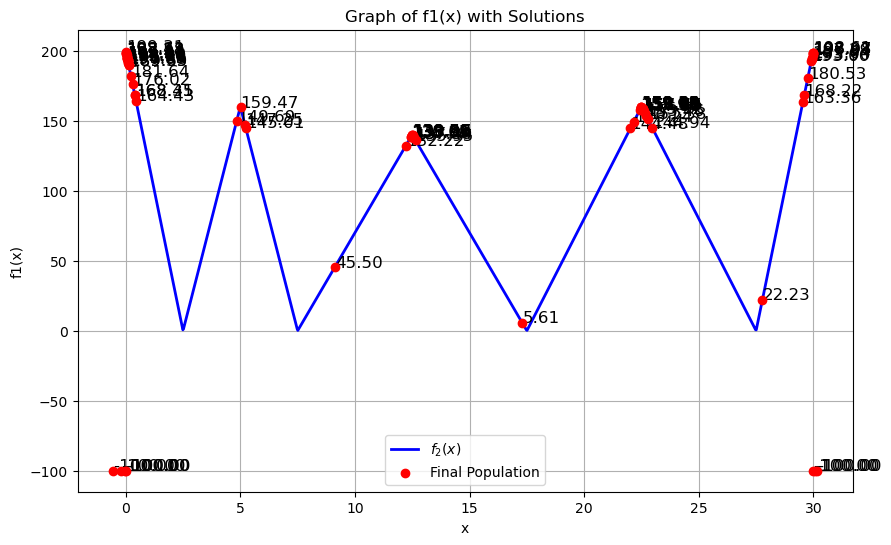

In [23]:
x_vals = np.linspace(0, 30, 1000)
y_vals = np.array([fitness_function(x) for x in x_vals])

final_population = population.flatten()
final_fitness = np.array([fitness_function(x) for x in final_population])

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label=r'$f_2(x)$', color='b', linewidth=2)
plt.title('Graph of f1(x) with Solutions')
plt.xlabel('x')
plt.ylabel('f1(x)')
plt.grid(True)

plt.scatter(final_population, final_fitness, color='r', zorder=5, label='Final Population')
for i, txt in enumerate(final_fitness):
    plt.annotate(f'{txt:.2f}', (final_population[i], final_fitness[i]), fontsize=12, color='black')

plt.legend()
plt.show()

## Testing with F2:

In [24]:
fitness_function = F2
lower_bound = 0
upper_bound = 1

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
        x1
0   0.5891
1   0.6434
2   0.4869
3   0.8636
4   0.8347
5   0.9560
6   0.2457
7   0.0689
8   0.1843
9   0.1547
10  0.2974
11  0.9121
12  0.8352
13  0.7828
14  0.7303
15  0.6321
16  0.4873
17  0.5264
18  0.9446
19  0.5665
20  0.2065
21  0.4912
22  0.7357
23  0.7545
24  0.2467
25  0.3849
26  0.8798
27  0.1874
28  0.2112
29  0.0081
30  0.7100
31  0.1253
32  0.8767
33  0.7124
34  0.3951
35  0.7725
36  0.4766
37  0.8417
38  0.8965
39  0.2697
40  0.3410
41  0.4161
42  0.8495
43  0.3088
44  0.8858
45  0.9861
46  0.4119
47  0.8793
48  0.3309
49  0.7689
50  0.5150
51  0.2847
52  0.0861
53  0.4156
54  0.4461
55  0.1843
56  0.2499
57  0.3093
58  0.2728
59  0.8051
60  0.6622
61  0.0660
62  0.5272
63  0.5335
64  0.6245
65  0.1499
66  0.3473
67  0.4129
68  0.7597
69  0.4939
70  0.2859
71  0.7358
72  0.5826
73  0.0128
74  0.6473
75  0.6924
76  0.3581
77  0.1160
78  0.7525
79  0.9255

Corresponding Fitness:
       Fitness
0   2.4077e-05
1   6.2589e-02
2   8.8037e-01
3 

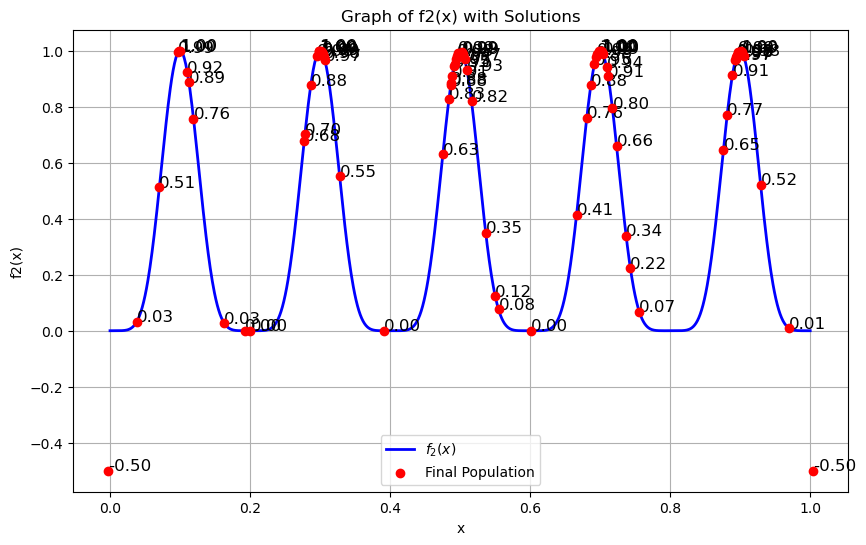

In [25]:
x_vals = np.linspace(0, 1, 1000)
y_vals = np.array([fitness_function(x) for x in x_vals])

final_population = population.flatten()
final_fitness = np.array([fitness_function(x) for x in final_population])

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label=r'$f_2(x)$', color='b', linewidth=2)
plt.title('Graph of f2(x) with Solutions')
plt.xlabel('x')
plt.ylabel('f2(x)')
plt.grid(True)

plt.scatter(final_population, final_fitness, color='r', zorder=5, label='Final Population')
for i, txt in enumerate(final_fitness):
    plt.annotate(f'{txt:.2f}', (final_population[i], final_fitness[i]), fontsize=12, color='black')

plt.legend()
plt.show()

## Testing with F3:

In [26]:
fitness_function = F3
lower_bound = 0
upper_bound = 1

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
        x1
0   0.2133
1   0.5413
2   0.4750
3   0.9523
4   0.4585
5   0.3083
6   0.2603
7   0.0278
8   0.6093
9   0.2283
10  0.8864
11  0.6463
12  0.2830
13  0.0445
14  0.9443
15  0.4295
16  0.0916
17  0.9011
18  0.0720
19  0.3189
20  0.8894
21  0.9272
22  0.9775
23  0.2567
24  0.2296
25  0.9307
26  0.7130
27  0.7182
28  0.8686
29  0.9850
30  0.1089
31  0.7821
32  0.0692
33  0.1687
34  0.9403
35  0.5226
36  0.4273
37  0.7316
38  0.9665
39  0.8137
40  0.8048
41  0.2411
42  0.3652
43  0.0905
44  0.7779
45  0.0266
46  0.4738
47  0.7809
48  0.7329
49  0.4701
50  0.0459
51  0.2153
52  0.8826
53  0.8842
54  0.7210
55  0.9490
56  0.2260
57  0.1795
58  0.2713
59  0.3505
60  0.5495
61  0.5650
62  0.1889
63  0.6402
64  0.5105
65  0.9695
66  0.6681
67  0.6412
68  0.2310
69  0.2354
70  0.1585
71  0.6984
72  0.6057
73  0.5692
74  0.3330
75  0.5117
76  0.7216
77  0.9843
78  0.1105
79  0.1992

Corresponding Fitness:
       Fitness
0   3.4778e-01
1   4.1661e-04
2   5.1326e-01
3 

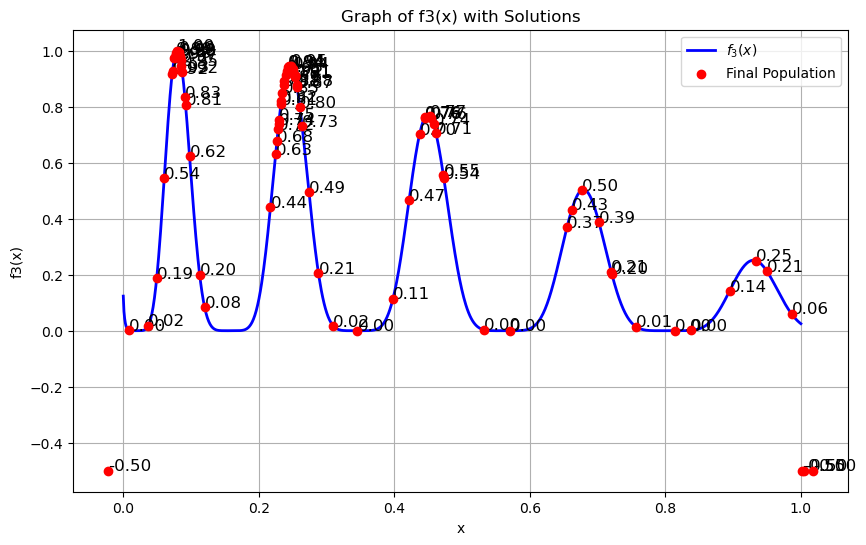

In [27]:
x_vals = np.linspace(0, 1, 1000)
y_vals = np.array([fitness_function(x) for x in x_vals])

final_population = population.flatten()
final_fitness = np.array([fitness_function(x) for x in final_population])

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label=r'$f_3(x)$', color='b', linewidth=2)
plt.title('Graph of f3(x) with Solutions')
plt.xlabel('x')
plt.ylabel('f3(x)')
plt.grid(True)

plt.scatter(final_population, final_fitness, color='r', zorder=5, label='Final Population')
for i, txt in enumerate(final_fitness):
    plt.annotate(f'{txt:.2f}', (final_population[i], final_fitness[i]), fontsize=12, color='black')

plt.legend()
plt.show()

## Testing with F4:

In [28]:
fitness_function = F4
lower_bound = -6
upper_bound = 6

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
        x1      x2
0   3.5467 -5.3898
1  -4.2296  3.8719
2  -1.3126  2.8651
3  -0.9402  5.0796
4  -4.9501 -2.3950
5  -4.3835  1.3109
6  -1.5488 -4.5457
7   1.2321 -0.8591
8  -0.3497  5.6114
9  -5.9607  0.5058
10  4.9087  2.6496
11 -5.8475  0.1815
12 -2.5254  5.9727
13 -5.7875 -5.5879
14 -2.6050  5.2103
15  3.7191 -3.4361
16 -4.7607 -5.0354
17 -2.1697  3.9288
18 -2.6539 -4.5366
19 -4.6379 -2.8477
20 -5.5169 -3.9318
21 -5.7221 -5.1506
22  0.1436  1.7160
23 -4.1273 -2.3639
24 -1.1978 -2.4625
25  3.9494  3.1099
26 -1.4910  5.2346
27  0.3548  1.1125
28 -3.9079 -2.6285
29  4.1401  1.9020
30  4.6371 -5.8855
31 -2.5780 -2.8337
32 -3.2610 -2.1280
33 -1.9856 -3.1274
34 -4.6162 -3.3762
35 -0.0107 -1.5762
36 -5.4524 -1.5620
37 -4.8050  2.5140
38  0.5952  2.5301
39 -1.8889  2.1036
40  2.8347 -1.7718
41 -2.0059  0.6468
42 -2.5713  3.1362
43  4.1064 -1.6123
44 -2.0124 -2.8097
45  2.0706  4.7659
46 -2.0282 -0.6015
47 -3.9483 -5.5081
48 -5.3898 -4.1172
49  4.1314 -5.2105
50 -0.00

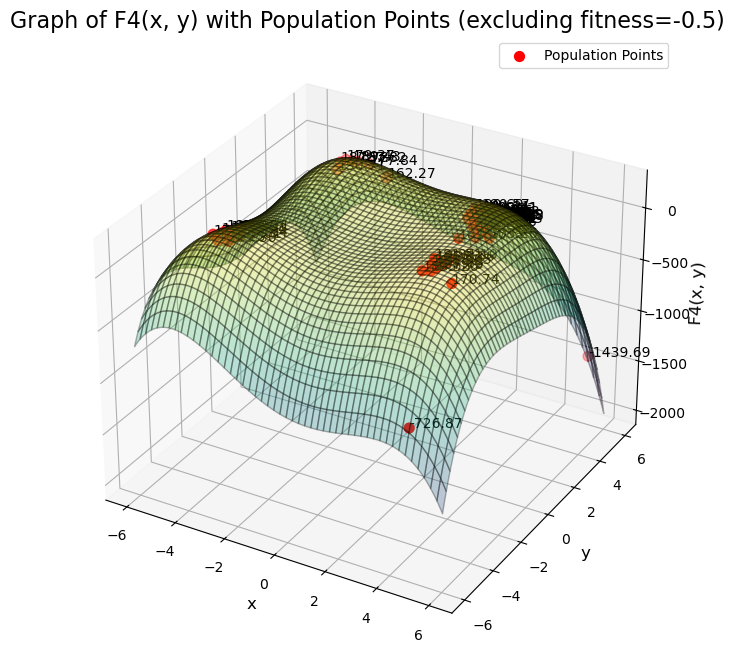

In [29]:
# out of bound points not shown

from mpl_toolkits.mplot3d import Axes3D

# Generate the grid for the 3D plot
x = np.linspace(-6, 6, 500)
y = np.linspace(-6, 6, 500)
X, Y = np.meshgrid(x, y)
Z = np.array([[F4(xi, yi) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Create a mask to filter out points with fitness == 0.5
mask = fitness != -0.5
filtered_population = population[mask]
filtered_fitness = fitness[mask]

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the Himmelblau function as a surface
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3, edgecolor='k')

# Scatter the filtered population points
ax.scatter(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness,
           color='r', s=50, label='Population Points', zorder=5)

# Annotate each filtered point with its fitness value
for (x_val, y_val, z_val) in zip(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness):
    ax.text(x_val, y_val, z_val, f'{z_val:.2f}', color='black', fontsize=10)

# Labels and legend
ax.set_title('Graph of F4(x, y) with Population Points (excluding fitness=-0.5)', fontsize=16)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('F4(x, y)', fontsize=12)
ax.legend()

# Show the plot
plt.show()


## Testing with F5:

In [30]:
fitness_function = F5
lower_bound = [-1.9, -1.1]
upper_bound = [1.9, 1.1]

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)


D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
        x1      x2
0  -0.5539  0.5609
1   0.2404  1.0461
2   1.1505 -0.6871
3   0.7828 -0.1352
4   0.3741 -0.2599
5   1.8288 -0.8690
6  -1.8713  0.0575
7   1.2769 -0.8489
8   1.5096  0.3729
9   0.9513 -0.5726
10  0.6200  0.3887
11  0.2351  0.6951
12  1.0646  0.9603
13  1.7453  1.0883
14  0.7794  0.3927
15  0.6134  0.3145
16  0.1318  1.0399
17  0.6530  0.9626
18 -0.8814  0.8442
19 -0.5539  0.1859
20  1.4663 -1.0699
21 -1.2489 -0.9726
22 -1.7682 -0.5656
23 -1.1292 -0.2657
24 -1.8880 -0.3291
25  0.3791 -1.0714
26  1.4100 -0.5632
27 -1.1363 -0.4400
28 -1.5712  0.9828
29 -0.6639 -1.0694
30 -1.1101 -0.9824
31 -0.0586 -0.1030
32  0.4872  0.3225
33 -1.5629 -0.3868
34  1.7736  0.4492
35 -1.7383 -0.4671
36 -1.2261 -1.0112
37  0.3901  0.5741
38  1.6299  0.0903
39 -1.5248 -0.9806
40  0.9425 -0.8727
41 -1.7085 -0.5177
42  1.7924  0.7358
43 -0.9495 -1.0041
44 -0.7279 -0.7473
45  1.8081 -0.7908
46 -0.0795 -0.0161
47  1.7546  0.8318
48 -1.5771 -0.4691
49  1.5740 -0.4829
50  0.34

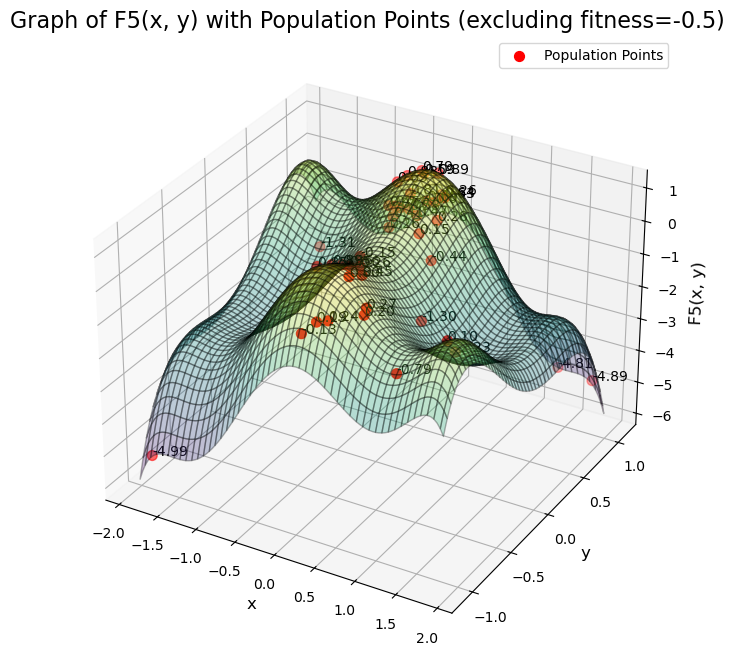

In [31]:
x = np.linspace(lower_bound[0], upper_bound[0], 100)
y = np.linspace(lower_bound[1], upper_bound[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.array([[F5(xi, yi) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

mask = fitness != -0.5
filtered_population = population[mask]
filtered_fitness = fitness[mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3, edgecolor='k')

ax.scatter(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness,
           color='r', s=50, label='Population Points', zorder=5)

for x_val, y_val, z_val in zip(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness):
    ax.text(x_val, y_val, z_val, f'{z_val:.2f}', color='black', fontsize=10)

ax.set_title('Graph of F5(x, y) with Population Points (excluding fitness=-0.5)', fontsize=16)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('F5(x, y)', fontsize=12)
ax.legend()

# Show the plot
plt.show()


## Standard Max_Fes & Population For F6:

In [32]:
NP = 100
G = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
local_search_std = 3
Max_Fes = 200_000

## Testing with F6:

In [33]:
fitness_function = F6
lower_bound = [-10, -10, -10, -10]
upper_bound = [10, 10, 10, 10]

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
        x1      x2      x3      x4
0   0.5187  6.5854  1.5441 -4.4880
1   5.8535  3.8251 -2.2806  9.9290
2   4.0098 -7.9731 -9.8341 -9.5748
3   1.6877  9.5334 -3.7936  3.9594
4  -3.6969 -5.7903  3.3497  6.3750
5   1.7741 -2.5494 -8.2249  1.8320
6   2.2879  9.8950  1.4722  1.9139
7  -6.9257  4.0863  9.1367  6.5192
8  -8.0739  3.2053 -5.5857 -8.8175
9  -4.4088 -7.6546 -9.9658 -5.8108
10 -3.1707  3.2504  8.5959 -6.5688
11  8.5271 -8.6370 -8.8002 -9.8859
12 -5.2076 -9.1980  9.0909 -3.6047
13 -0.8689  6.6849  5.9383  4.9777
14  2.8957  6.8625  8.4333  0.5728
15  9.9529  3.2241 -4.1896 -9.5828
16  0.5064  4.5090 -4.9239  3.1603
17 -6.2347 -3.7484  5.8153 -9.6051
18  2.1583 -9.4549  1.9804  0.4276
19 -5.7688  0.2366  6.3575  6.2277
20  5.0301  5.8232  6.8795  0.9317
21 -1.3861 -2.5762 -0.1970  1.9751
22  0.0953 -8.4226 -2.2833 -2.7852
23 -2.0734 -8.4897 -2.9569  8.4008
24  3.1688 -2.6874 -1.3047 -3.2181
25 -2.0683  3.2886  9.7958  8.1698
26 -3.3753  2.1256 -4.3285 -1.79

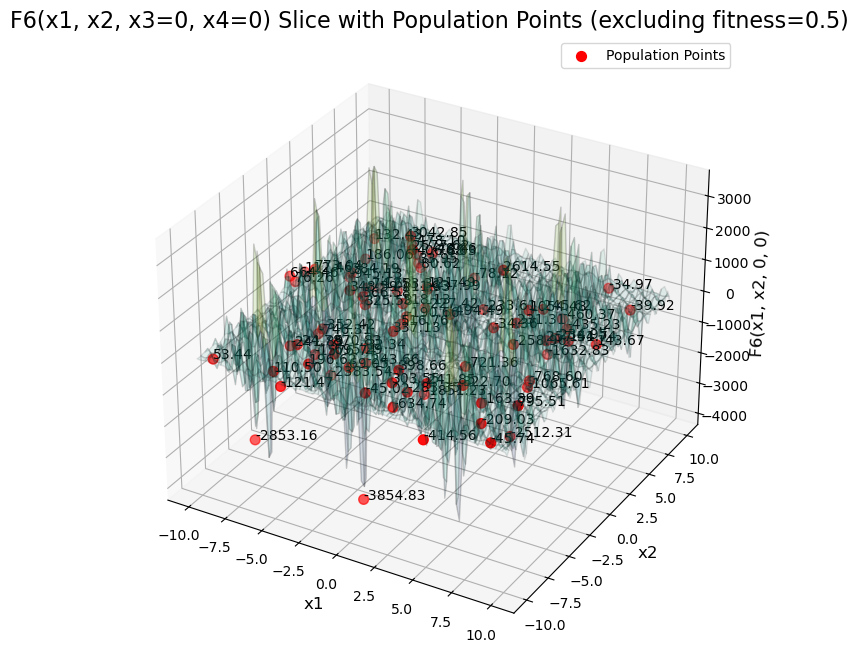

In [34]:
# Fixed parameters for x3, x4 slice
x3_fixed = 0.0
x4_fixed = 0.0

lower_bound = [-10, -10]
upper_bound = [10, 10]

x = np.linspace(lower_bound[0], upper_bound[0], 100)
y = np.linspace(lower_bound[1], upper_bound[1], 100)
X, Y = np.meshgrid(x, y)

# Compute Z values for the slice of F6 where x3=x3_fixed and x4=x4_fixed
Z = np.array([[F6(xi, yi, x3_fixed, x4_fixed) for xi, yi in zip(row_x, row_y)]
              for row_x, row_y in zip(X, Y)])

# Compute the slice-based fitness for the population
fitness_slice = np.array([F6(ind[0], ind[1], x3_fixed, x4_fixed) for ind in population])

# Create a mask to filter out points with fitness_slice == 0.5
mask = fitness_slice != -0.5
filtered_population = population[mask]
filtered_fitness_slice = fitness_slice[mask]

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the F6 function (slice) as a surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.1, edgecolor='k')

# Scatter the filtered population points (projected onto the slice)
ax.scatter(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness_slice,
           color='r', s=50, label='Population Points', zorder=5)

# Annotate each filtered point with its slice-based fitness value
for (x_val, y_val, z_val) in zip(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness_slice):
    ax.text(x_val, y_val, z_val, f'{z_val:.2f}', color='black', fontsize=10)

# Labels and legend
ax.set_title('F6(x1, x2, x3=0, x4=0) Slice with Population Points (excluding fitness=0.5)', fontsize=16)
ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
ax.set_zlabel('F6(x1, x2, 0, 0)', fontsize=12)
ax.legend()

plt.show()


## Standard Max_Fes & Population For F7:

In [35]:
NP = 300
G = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
local_search_std = 3
Max_Fes = 200_000

## Testing with F7:

In [36]:
fitness_function = F7
lower_bound = [0.25, 0.25, 0.25, 0.25]
upper_bound = [10, 10, 10, 10]

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1] 
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
         x1      x2      x3      x4
0    7.4693  2.0119  6.1160  9.4390
1    3.7025  6.8540  6.1872  7.4359
2    2.0163  0.9179  7.4485  9.1889
3    3.2321  9.0313  7.2582  7.5530
4    4.4665  6.7981  4.6702  3.8083
..      ...     ...     ...     ...
295  7.7355  0.2889  3.3070  0.5031
296  5.8344  5.6708  6.1331  6.2889
297  1.0950  3.5747  3.9502  1.8526
298  5.3001  6.5423  5.4226  1.9328
299  5.9707  1.6102  3.2819  9.7403

[300 rows x 4 columns]

Corresponding Fitness:
     Fitness
0     0.1214
1     0.3101
2     0.1664
3     0.2622
4     0.5000
..       ...
295   0.0068
296  -0.7582
297   0.4410
298  -0.3801
299  -0.7894

[300 rows x 1 columns]

--------------------------------------------------
Iteration: 300/200000 Fitness Evaluations
FSmax: 0.9506, FSmin: -0.8495
Niching Size NS: 15

Using Algorithm 1 to create Clusters:

  Cluster 1 (Size: 15):
    x1     x2     x3     x4
4.7225 5.1474 0.6769 4.6977
6.0885 5.8486 1.3955 4.0759
3.2625 3.4667 0.9303 4.19

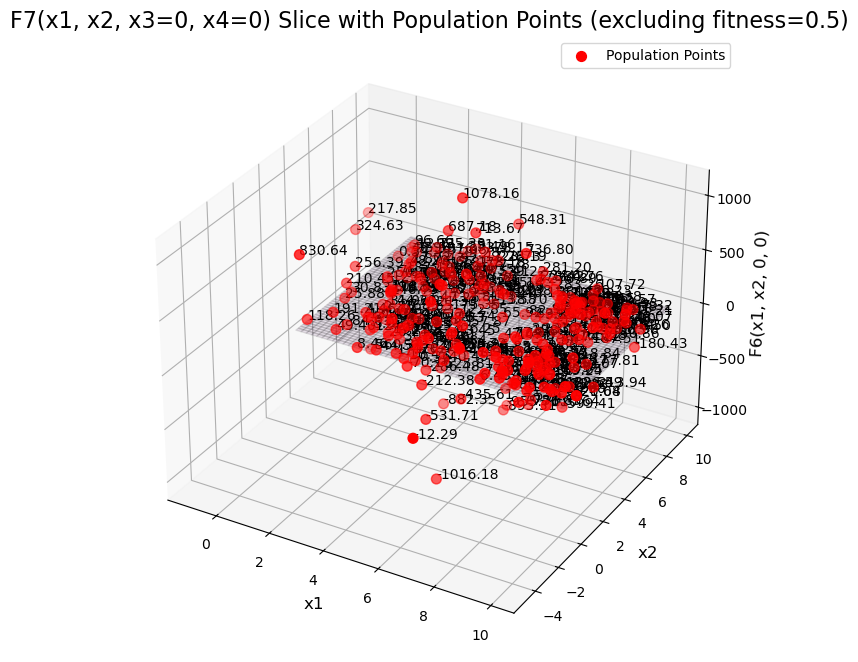

In [37]:
# Fixed parameters for x3, x4 slice
x3_fixed = 0.0
x4_fixed = 0.0

lower_bound = [0.25, 0.25, 0.25, 0.25]
upper_bound = [10, 10, 10, 10]

x = np.linspace(lower_bound[0], upper_bound[0], 100)
y = np.linspace(lower_bound[1], upper_bound[1], 100)
X, Y = np.meshgrid(x, y)

# Compute Z values for the slice of F6 where x3=x3_fixed and x4=x4_fixed
Z = np.array([[F7(xi, yi, x3_fixed, x4_fixed) for xi, yi in zip(row_x, row_y)]
              for row_x, row_y in zip(X, Y)])

# Compute the slice-based fitness for the population
fitness_slice = np.array([F6(ind[0], ind[1], x3_fixed, x4_fixed) for ind in population])

# Create a mask to filter out points with fitness_slice == 0.5
mask = fitness_slice != -0.5
filtered_population = population[mask]
filtered_fitness_slice = fitness_slice[mask]

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the F6 function (slice) as a surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.1, edgecolor='k')

# Scatter the filtered population points (projected onto the slice)
ax.scatter(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness_slice,
           color='r', s=50, label='Population Points', zorder=5)

# Annotate each filtered point with its slice-based fitness value
for (x_val, y_val, z_val) in zip(filtered_population[:, 0], filtered_population[:, 1], filtered_fitness_slice):
    ax.text(x_val, y_val, z_val, f'{z_val:.2f}', color='black', fontsize=10)

# Labels and legend
ax.set_title('F7(x1, x2, x3=0, x4=0) Slice with Population Points (excluding fitness=0.5)', fontsize=16)
ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
ax.set_zlabel('F6(x1, x2, 0, 0)', fontsize=12)
ax.legend()

plt.show()

## Standard Max_Fes & Population For F8 and F9:

In [41]:
NP = 300
G = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
local_search_std = 3
Max_Fes = 400_000

## Testing with F8:

In [44]:
# Test F8 with specified bounds
fitness_function = F8
lower_bound = [0, 0]
upper_bound = [1, 1]

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
         x1      x2
0    0.8291  0.3535
1    0.9060  0.0649
2    0.7545  0.1292
3    0.1787  0.3735
4    0.8093  0.8493
..      ...     ...
295  0.7418  0.9772
296  0.4711  0.4287
297  0.0284  0.1260
298  0.9321  0.6940
299  0.6217  0.3701

[300 rows x 2 columns]

Corresponding Fitness:
     Fitness
0    -7.5928
1   -18.3933
2   -17.3647
3   -18.2196
4    -6.5451
..       ...
295  -8.5842
296 -12.6753
297 -18.9977
298  -4.5673
299 -11.1246

[300 rows x 1 columns]

--------------------------------------------------
Iteration: 300/400000 Fitness Evaluations
FSmax: -1.0002, FSmin: -19.0000
Niching Size NS: 9

Using Algorithm 1 to create Clusters:

  Cluster 1 (Size: 9):
    x1     x2
0.8502 0.3521
0.8291 0.3535
0.8581 0.3728
0.8279 0.3526
0.8291 0.3977
0.9049 0.3883
0.8621 0.2855
0.9234 0.3270
0.9055 0.2959

  Cluster 2 (Size: 9):
    x1     x2
0.8928 0.2684
0.9426 0.2076
0.9829 0.2889
0.9858 0.2840
0.8171 0.2052
0.9698 0.3320
0.9775 0.3226
0.8945 0.1626
0.9392 0.36

ValueError: All elements of x must be within the range [0, 1].

## Testing with F9:

In [45]:
# Test F8 with specified bounds
fitness_function = F9
lower_bound = [0, 0, 0, 0]
upper_bound = [1, 1, 1, 1]

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")


Population Generated:
         x1      x2      x3      x4
0    0.0293  0.4044  0.0663  0.5215
1    0.4754  0.8573  0.8104  0.7265
2    0.2477  0.3268  0.2017  0.5194
3    0.7396  0.9334  0.9484  0.0744
4    0.3604  0.1658  0.8355  0.0750
..      ...     ...     ...     ...
295  0.4125  0.4000  0.5689  0.1421
296  0.8462  0.0735  0.8859  0.5228
297  0.4111  0.0150  0.2526  0.9197
298  0.6223  0.5013  0.6788  0.7140
299  0.5772  0.0179  0.4951  0.7894

[300 rows x 4 columns]

Corresponding Fitness:
        Fitness
0    28462.3128
1    28462.3128
2    28462.3128
3    28462.3128
4    28462.3128
..          ...
295  28462.3128
296  28462.3128
297  28462.3128
298  28462.3128
299  28462.3128

[300 rows x 1 columns]

--------------------------------------------------
Iteration: 300/400000 Fitness Evaluations
FSmax: 28462.3128, FSmin: 28462.3128
Niching Size NS: 2

Using Algorithm 1 to create Clusters:

  Cluster 1 (Size: 2):
    x1     x2     x3     x4
0.8242 0.2223 0.8392 0.7984
0.9213 0.284

KeyboardInterrupt: 

## Standard Max_Fes & Population For F10:

In [ ]:
NP = 100
G = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
local_search_std = 3
Max_Fes = 200_000

## Testing with F10:

In [ ]:
fitness_function = F10
lower_bound = [0, 0, 0, 0]
upper_bound = [1, 1, 1, 1]

population, fitness = Local_Search_Based_AMC_ACO(NP, G, local_search_std)

D = population.shape[1]  # number of dimensions
col_names = [f"x{i+1}" for i in range(D)]
df_population = pd.DataFrame(population, columns=col_names)

df_population["Fitness"] = fitness

pd.set_option('display.precision', 4)   # Control decimal places
pd.set_option('display.max_rows', 100)  # Control max rows displayed
pd.set_option('display.width', 1000)    # Control the width to avoid wrapping

print("\n" + "="*50)
print("Final Population and Fitness:")
print(df_population)
print("="*50 + "\n")